In [1]:
# !pip install transformers
# from google.colab import drive
# drive.mount('/content/drive')
from transformers import pipeline
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TSW\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\TSW\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


GPU is not available


In [2]:
file_path = 'C:/Users/TSW/Desktop/plp_project/plp_practice_proj/sentiment_analysis_sw/labelled_dataset_sentence_level_clean.csv'
df = pd.read_csv(file_path)

In [3]:
########### using sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device = -1)
# List to store the results
results = []
def truncate_to_max_length(text, max_length):
    encoded_input = tokenizer(text, truncation=True, max_length=max_length, return_tensors='pt')
    return tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=True)

for index, row in tqdm(df.iterrows(), total=len(df), ncols=100):
    review = row['sentence']
    label = row['label']

    # Sentence tokenization
    for sentence in sent_tokenize(review):
        truncated_sentence = truncate_to_max_length(sentence, max_length=512)
        # Get sentiment for the sentence
        sentiment_result = sentiment_analyzer(truncated_sentence)[0]

        # Extract sentiment label and score
        sentiment_label = sentiment_result['label']
        sentiment_score = sentiment_result['score']

        # Append results
        results.append({
            # "subreddit": subreddit,
            # "created_utc": created_utc,
            "sentence": sentence,
            "d_prediction": sentiment_label,
            "sentiment_score": sentiment_score,
            "label": label
        })


100%|███████████████████████████████████████████████████████████| 8313/8313 [04:31<00:00, 30.58it/s]


In [4]:
sentiment_df = pd.DataFrame(results)

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize,sent_tokenize
from tqdm import tqdm
vader_obj = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if isinstance(text, str):
        return vader_obj.polarity_scores(text)
    else:
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}  # Return neutral for non-strings
    
def get_sentiment_label(compound_score):
    """Assign sentiment label based on VADER sentiment scores."""
    if compound_score > 0.05:
        return 'POSITIVE'
    elif compound_score < -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

In [6]:
sentiment_df[['neg', 'neu', 'pos', 'compound']] = sentiment_df['sentence'].apply(get_sentiment).apply(pd.Series)
sentiment_df['v_prediction'] = sentiment_df['compound'].apply(get_sentiment_label).apply(pd.Series)

In [7]:
def hybrid_sentiment(row):
    if row['d_prediction'] == row['v_prediction']:
        return row['d_prediction']  # If both are the same, return the common sentiment
    else:
        return 'NEUTRAL'  # If they are different, return 'NEUTRAL'

# Apply the function to each row
sentiment_df['hybrid_prediction'] = sentiment_df.apply(hybrid_sentiment, axis=1)

In [8]:
sentiment_df.hybrid_prediction.value_counts()

NEUTRAL     5272
NEGATIVE    1784
POSITIVE    1313
Name: hybrid_prediction, dtype: int64

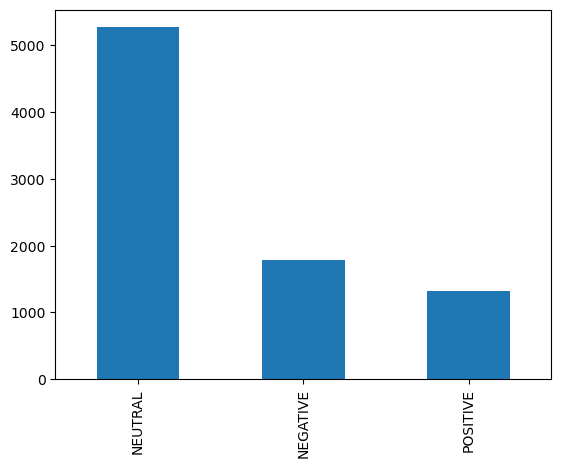

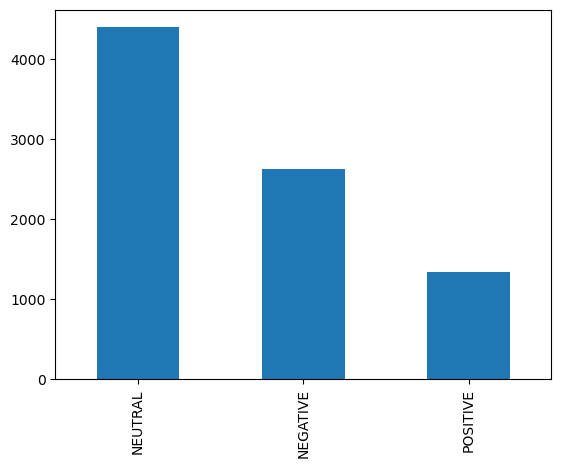

NEUTRAL     4401
NEGATIVE    2623
POSITIVE    1345
Name: label, dtype: int64
NEUTRAL     5272
NEGATIVE    1784
POSITIVE    1313
Name: hybrid_prediction, dtype: int64


In [9]:
sentiment_df['hybrid_prediction'].value_counts().plot(kind='bar')
plt.show()
sentiment_df['label'].value_counts().plot(kind='bar')
plt.show()
print(sentiment_df['label'].value_counts())
print(sentiment_df['hybrid_prediction'].value_counts())

Accuracy: 0.61
Recall: 0.61
F1 Score: 0.61


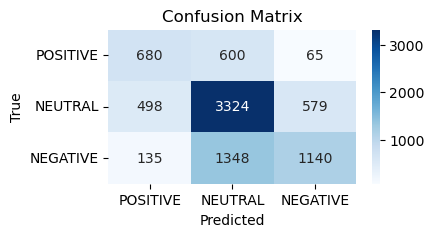

In [10]:
predictions = sentiment_df['hybrid_prediction']
labels = sentiment_df['label']

cm = confusion_matrix(labels, predictions, labels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

accuracy = accuracy_score(labels, predictions)
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
df_eval = sentiment_df
y_true = df_eval['label']
y_pred = df_eval['hybrid_prediction']
cm = confusion_matrix(y_true, y_pred, labels=['POSITIVE', 'NEGATIVE', 'NEUTRAL'])

# Compute accuracy
true_positives = cm.diagonal()
total_actual = cm.sum(axis=1)

# Calculate per-class accuracy
accuracy_per_class = true_positives / total_actual
accuracy_pos, accuracy_neg, accuracy_neu = accuracy_per_class


# Compute recall (per class average)
recall = recall_score(y_true, y_pred, average=None, labels=['POSITIVE', 'NEGATIVE', 'NEUTRAL'])

# Compute F1 Score
f1_scores = f1_score(y_true, y_pred, labels=['POSITIVE', 'NEGATIVE', 'NEUTRAL'], average=None)
f1_pos, f1_neg, f1_neu = f1_scores

# Type 1 Error (False Positive Rate) - per class
type_1_error = 1 - recall  # Since FPR = 1 - recall (when averaged across classes)

# Compute Type 2 Error (False Negative Rate)
# Type 2 error (FNR) is simply: 1 - recall per class
type_2_error = 1 - recall

# Output the results
print(f"Confusion Matrix:\n{cm}")
print("----------------------------------------")
print(f"Recall (per class): {recall}")
print(f"Type 1 Error (per class): {type_1_error}")
print(f"Type 2 Error (per class): {type_2_error}")

# Print accuracy for each class
print("----------------------------------------")
print(f"Accuracy for 'POSITIVE': {accuracy_pos}")
print(f"Accuracy for 'NEGATIVE': {accuracy_neg}")
print(f"Accuracy for 'NEUTRAL': {accuracy_neu}")

# Print F1 scores for each class
print("----------------------------------------")
print(f"F1 Score for 'POSITIVE': {f1_pos}")
print(f"F1 Score for 'NEGATIVE': {f1_neg}")
print(f"F1 Score for 'NEUTRAL': {f1_neu}")

Confusion Matrix:
[[ 680   65  600]
 [ 135 1140 1348]
 [ 498  579 3324]]
----------------------------------------
Recall (per class): [0.50557621 0.43461685 0.75528289]
Type 1 Error (per class): [0.49442379 0.56538315 0.24471711]
Type 2 Error (per class): [0.49442379 0.56538315 0.24471711]
----------------------------------------
Accuracy for 'POSITIVE': 0.5055762081784386
Accuracy for 'NEGATIVE': 0.434616850934045
Accuracy for 'NEUTRAL': 0.7552828902522154
----------------------------------------
F1 Score for 'POSITIVE': 0.5116629044394281
F1 Score for 'NEGATIVE': 0.5173587474472431
F1 Score for 'NEUTRAL': 0.6872738550604777


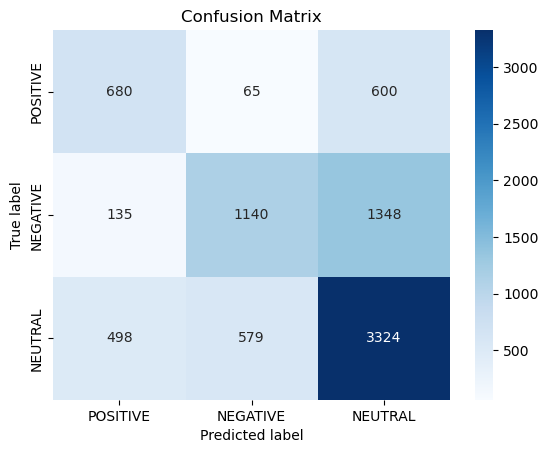

In [12]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['POSITIVE', 'NEGATIVE', 'NEUTRAL'], yticklabels=['POSITIVE', 'NEGATIVE', 'NEUTRAL'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()